In [10]:
import os
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd
import pickle
from scipy.optimize import fsolve
from multiprocessing import Pool
from collections import ChainMap
%matplotlib inline  
import FatTreeLibrary as ft

In [2]:
SP=pickle.load( open( "../../../AllShortestPaths/allShortestPathsK16.pkl", "rb" ) )

In [3]:
ftree=ft.getFatTree(16)

In [4]:
servers=ftree[1]
links=ftree[0]


In [5]:
routing=ft.ECMPFromDict(demands,SP)

In [6]:
routingLinks=np.array([ft.nodesToLinksIndexes(r,links) for r in routing])

In [11]:
C=np.array([10 for l in links])
CUsed=np.array([0. for l in links])

In [8]:
rates=ft.max_min_allocation(C,routingLinks)

In [9]:
time_to_completion=demands[:,2]/rates

In [10]:

for i in range(len(routingLinks)):
    path=routingLinks[i]
    rate=rates[i]
    CUsed[path]+=rate

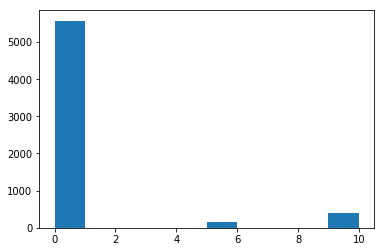

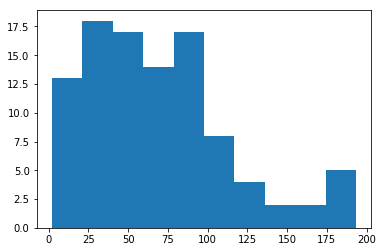

In [11]:
plt.hist(CUsed)
plt.show()
plt.hist(time_to_completion)
plt.show()

In [73]:
demands=ft.getDemands(10,100,servers)
routing=ft.ECMPFromDict(demands,SP)
routingLinks=[ft.nodesToLinksIndexes(r,links) for r in routing]

In [114]:
C=np.array([10. for x in links])

In [47]:
rates=ft.max_min_allocation(C,routingLinks)

In [48]:
rates

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10.])

In [145]:
ind=np.array([i for i in range(len(demands))])
activeIndexes=ind[ind!=-1]
activeIndexes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [146]:
demands

array([[474, 465,   2],
       [846, 421,   6],
       [753, 895,   3],
       [772, 287,   2],
       [359, 310,  23],
       [518, 719,  30],
       [ 24, 495,   6],
       [835, 980,   4],
       [414, 256,   4],
       [434, 273,   7]])

In [49]:
x=demands[:,2]/rates
print (x)

[0.5 0.2 6.6 0.1 1.7 0.  0.2 4.3 2.9 4.3]


In [21]:
links[links[:,0]==0]

array([[   0, 1024]])

In [179]:
#demands: nx3 np.array[[sources,destinations,amount]]
#routingLinks: list of paths, each path is a list of links encoded as [(s_1,d_2),(s_2,d_2),...,(s_n,d_n)]
#C: np.array recording the capacity of each link
def completionTimesECMP(demands,routingLinks,C):
    #copy demands and routingLinks to local varibles
    demands=np.array(demands)
    routingLinks=list(routingLinks)
    #time_to_completion keeps track of the time to completion of each demand 
    #as if the allocation stays always  the same
    time_to_completion=np.zeros(len(demands))
    #times keeps track of the actual time to completion of the demands as they progressively expire
    times=np.zeros(len(demands))
    #ind keeps track of active and expired flows
    ind=np.arange(len(demands))
    activeIndexes=ind[ind!=-1]
    #initial rate allocation
    rates=ft.max_min_allocation(C,routingLinks)
    troughputs=[0]
    while np.sum(ind)>-len(ind):#iterate until all flows are expired
        #compute the time to completion of each demand, given current rate allocation, 
        #as if the rate stay always the same
        time_to_completion[activeIndexes]=demands[activeIndexes,2]/rates[activeIndexes]
        #get the minimum time to completion
        minT=min(time_to_completion[activeIndexes])
        #update the times of completion for all flows
        times[activeIndexes]+=minT
        #decrement the amount of data to be transmitted for each demand
        demands[activeIndexes,2]=demands[activeIndexes,2]-rates[activeIndexes]*minT
        troughputs.append(np.sum(rates[activeIndexes]))
        #mark expired flows as inactive and update the activeIndexes array
        ind[(time_to_completion==minT)&(ind!=-1)]=-1
        activeIndexes=ind[ind!=-1]
        #run max-min allocation on the remaining flows, and iterate
        routingLinks_=[routingLinks[i] for i in activeIndexes]#max_min_allocation wants 'paths' as list
        rates_=ft.max_min_allocation(C,routingLinks_)
        rates[activeIndexes]=rates_
    return times, troughputs

In [212]:
demands=ft.getDemands(5000,100,servers)


In [14]:
t=completionTimes(demands,routingLinks,C)

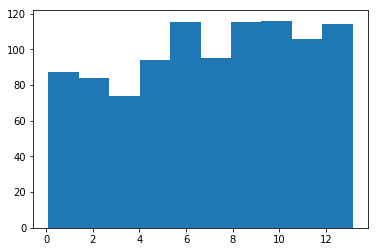

In [17]:
plt.hist(t)
plt.show()

In [19]:
np.argmin([0,2,3,4,0])

0

In [13]:
def routeBigFlow(shortest_paths,linksUsage):
    pathInd=np.argmin([np.min([linksUsage[(s[i],s[i+1])] for i in range(len(s)-1)]) for s in shortest_paths])
    return shortest_paths[pathInd]


In [222]:
demands=ft.getDemands(100,100,servers)

In [234]:
Threshold=90
I=np.where(demands[:,-1]>Threshold)[0]
J=np.where(demands[:,-1]<=Threshold)[0]
smallDemands=demands[J]
bigDemands=demands[I]
baseRouting=ft.ECMPFromDict(demands,SP)
baseRoutingLinks=[ft.nodesToLinksIndexes(r,links) for r in baseRouting]
baseRates=ft.max_min_allocation(C,baseRoutingLinks)


R=list(J)
smartRouting=list(ft.ECMPFromDict(demands[J],SP))
smartRoutingLinks=[ft.nodesToLinksIndexes(r,links) for r in smartRouting]
smartRates=ft.max_min_allocation(C,smartRoutingLinks)
linksUsage={(l[0],l[1]):0 for l in links}
p=0
for ii in I:
    d=demands[ii]
    linksUsage = dict.fromkeys(linksUsage, 0)
    for i in range(len(smartRouting)):
        path=smartRouting[i]
        for j in range(len(path)-1):
            #print(j)
            #print(path[j])
            #print(path[j+1])
            #rint(smartRates[i])
            #print(linksUsage[(path[j],path[j+1])])
            linksUsage[(path[j],path[j+1])]+=smartRates[i]
    if d[0]>d[1]:
        Shortests=[x[::-1] for x in SP[(d[1],d[0])]]
    else:
        Shortests=SP[(d[0],d[1])]
    routing=routeBigFlow(Shortests,linksUsage)
    smartRouting.append(routing)
    smartRoutingLinks.append(ft.nodesToLinksIndexes(routing,links))
    
    R.append(ii)
    smartRates=ft.max_min_allocation(C,smartRoutingLinks)
    print (p,end=',')
    p+=1
rates=[smartRates[j] for j in R]
smartRouting=[smartRoutingLinks[j] for j in R]

0,1,2,3,4,5,6,7,8,

In [245]:
I

array([ 4, 34, 40, 41, 54, 68, 70, 91, 94])

In [240]:
print (np.sum(baseRates))
print (np.sum(rates))
print (np.array(rates)[I]*bigDemands[:,2])
print (baseRates[I]*bigDemands[:,2])

821.6666666666666
783.3333333333334
[910.         940.         920.         920.         990.
 303.33333333 970.         495.         323.33333333]
[910.         940.         920.         920.         990.
 455.         646.66666667 495.         970.        ]


In [239]:
np.array(rates)[I]*bigDemands

ValueError: operands could not be broadcast together with shapes (9,) (9,3) 

In [241]:
C0=completionTimesECMP(demands,baseRoutingLinks,C)

In [242]:
C1=completionTimesECMP(demands,smartRouting,C)

5.970999999999999
6.205999999999997


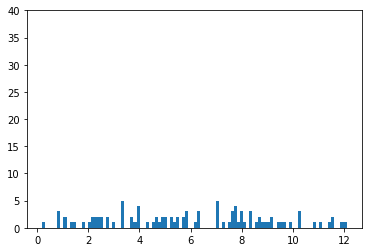

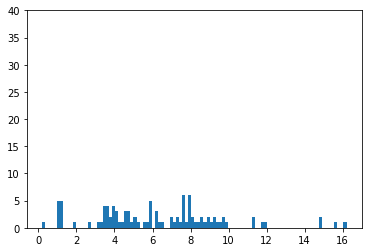

In [243]:
print(np.average(C0[0]))
print(np.average(C1[0]))
plt.hist(C0[0],100)
plt.ylim(0,40)
plt.show()

plt.hist(C1[0],100)
plt.ylim(0,40)
plt.show()

In [201]:
np.max(list(linksUsage.values()))

10.000000000000016

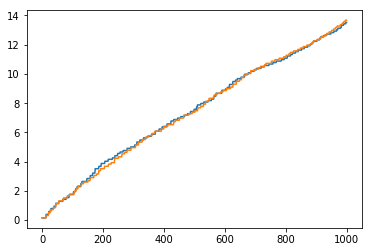

In [209]:
plt.plot(np.sort(C0[0]))

plt.plot(np.sort(C1[0]))
plt.show()

In [210]:
len(servers)

1024

In [97]:
nodes=list(set([(random.randint(1,100),random.randint(1,100)) for i in range (20) ]))

In [99]:
C={(n[0],n[1]):10 for n in nodes}

In [ ]:
links=[[(0,1),(1,2),(2,3),(5,6),(6,9),(9,20),(20,1000)]
paths=[
        [(0,1),(1,2),(2,3)],
        [(5,6),(6,9),(9,20),(20,1000)]
      ]
C={l:10 for l in links}